# Predict students' graduation rate

dataset 
- [from @ roycekimmons.com](http://roycekimmons.com/tools/generated_data/graduation_rate)

> This is a fictional dataset and should only be used for data science training purposes.
> 
> This data set includes graduation rates from a four-year college with a variety of student factors.

The key questions we want to address:

> 1. How effective are entrance requirements at predicting gpa and graduation rate?
> 1. What would be the best way to improve graduation rates?

> All data sets are generated on-the-fly. So, you can increase your n by downloading a data set multiple times and combining the files. (n=1000) per large sample download

Based on the above statement, I have downloaded 5x times and combined them into one csv file so that we can work with a larger sample size of 5000 observations, instead of just 1000 observations.

Target is `'graduate_in_5years'` and column named simply as `'target'`
- feature-engineered from 'years_to_graduate' as 
  - 0: 'Yes' ie 'years_to_graduate' < 6
  - 1: 'No' ie 'years_to_graduate' > 5 
- was set to 4 years initially until EDA reveals median is 5.


In [74]:
import sys
from pathlib import Path
import logging
from contextlib import redirect_stdout

# Configure the logging library.
logging.basicConfig(filename='randomizedcv_tuning.log', level=logging.INFO)

# Set the path to the current file
current_file_path = Path().resolve()
print(f'{current_file_path = } ')
        
# Set the path to the data folder
data_folder_path = current_file_path / 'data' 
print(f'{data_folder_path = } ')

# Set the path to the src folder
src_folder_path = current_file_path / 'src'
print(f'{src_folder_path = } ')

# Add the src folder to the system path
sys.path.append(str(src_folder_path))

# Import modules from files under /src
from src.config import * 
from src.data_loader import CSVDataLoader
from src.data_preprocessor import Preprocessor
from src.data_feature_builder import FeatureBuilder

current_file_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms') 
data_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/data') 
src_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/src') 


## Import packages

In [75]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [76]:
# not supported for HistGradientBoostingClassifier/ CatBoostClassifier
# from sklearnex import patch_sklearn
# patch_sklearn()

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

import catboost
from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, confusion_matrix, classification_report


In [77]:
import sklearn
sklearn.__version__

'1.3.1'

## Overview

> do we want 
> - 2 splits for train, test or 
> - 3 splits for train, val and test?
>
> reminder: 
> - not yet stratify
> - not scaled
> - use cross-validation 
> - save final df to file as processed_df.csv?

In this notebook, we're finally going to address the above questions. We're using 
- KFolds to cross-validate our data splitting,
- using just 3 features that were shown as the most important features via EDA
- scale our data, treat outliers ~~using Pipelines~~,
- perform hyperparameters tuning on the 2 classifiers with highest `'val auc'` scores,
- finally, the final chosen "best model" would be identified, and 
- creating scripts out of our POC code would commenced, and that would allow
- save our model to a `.pkl` file for us to deploy model to a web servic.e


## Hyperparameters Tuning

### Putting it all together

Based on findings from baseline scoring, we're gonna limit our GridSearch and hyperparameters tuning to just these 2 classifiers.

Perform data preprocessing and use pipelines to perform hyperparameter tuning to a couple of the models from previous top 2 performers:

- HistGradientBoostingClassifier()
- CatBoostClassifier()


In [ ]:
# scores = []

In [78]:
# declare the features we're using to train the model
features = ['sat_total_score', 'parental_level_of_education', 'parental_income', 'college_gpa'] 
# graduate_in_5years simply labeled as 'target'
target_name = 'target'


### test source



In [79]:
def rebuild_df():
    # Data ingestion
    data = CSVDataLoader().load(data_folder_path / 'graduation_rate.csv')
    print("- Preprocessor()...")
    data = Preprocessor().ColumnsSymbolReplacer(data)
    # display(f'{data.iloc[0:1] = }')
    # display(f'{data.iloc[11:12] = }')
    # display(data.head(2))
    data = Preprocessor().SymbolReplacer(
        data, 'parental_level_of_education')
    # display(data.head(2))
    data = Preprocessor().ColumnsDropper(data, TO_DROP)
    # display(data.head(2))
    print("- FeatureBuilder()...")
    data = FeatureBuilder().Target_encoder(data)
    # display(data.head(2))
    print("  -- Split TARGET_NAME for y...")
    target = data[TARGET_NAME]
    print("  -- Dropping TARGET_NAME...")
    data = data.drop(columns=TARGET_NAME)
    # display(data.head(2))
    print()
    print("  -- Set COLS_CATEGORICAL astype(category)...")
    data[COLS_CATEGORICAL] = data[COLS_CATEGORICAL].astype('category')
    # display(data.head(2))
    data = Preprocessor().DataScaler(data)
    # display(data.head(2))

    df_full_train, df_test, y_full_train, y_test = train_test_split(
        data, target, test_size=0.2, random_state=11)

    # reset indices back to begin from 0
    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_full_train = y_full_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return df_full_train, df_test, y_full_train, y_test


In [80]:
df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=11)
df_full_train.head()

Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 285.71it/s]

Finished processing the CSV file.
df.shape = (5000, 7)
- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
- FeatureBuilder()...
  -- Creating 'target' column...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...

  -- Set COLS_CATEGORICAL astype(category)...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...


,parental_level_of_education,sat_total_score,parental_income,college_gpa
0,some college,0.581050,-0.165044,0.600000
1,some high school,0.235160,-1.011711,0.266667
2,some high school,0.333333,-1.570150,0.400000
3,some college,0.643836,-0.680588,0.400000
4,high school,0.743151,-0.856499,0.600000


### Hyperparams Tuning on HistGradientBoostingClassifier

#### setup



In [81]:
# AUC is not a defined scoring metric for RandomizedSearchCV
scoring = {
    "AUC": make_scorer(roc_auc_score), 
    "Accuracy": make_scorer(accuracy_score), 
    "F1": make_scorer(f1_score),
    "Precision": make_scorer(precision_score), 
    "Recall": make_scorer(recall_score)}

# custom_loss=['Accuracy', 'AUC:hints=skip_train~false', 'F1','Precision', 'Recall']

In [82]:
hist_param_grid = {
    # 'classifier__loss': 'log_loss',                        # defaults, same as catboost's loss_function
    # 'classifier__categorical_features': COLS_CATEGORICAL,  # defaults, same as catboost's cat_features
    'learning_rate': LEARNING_RATE,    # defaults=0.1, 1=no shrinkage
    'max_iter': MAX_ITER,         # defaults=100; max num iterations/trees
    'max_depth': MAX_DEPTH,          # defaults=None; max depth of each tree
    'max_leaf_nodes': MAX_LEAF_NODES,    # defaults=31;max num of leaves
    'min_samples_leaf': MIN_SAMPLES_LEAF,  # defaults=20; min num of samples per leaf
    'early_stopping': ['auto', True],       # defaults='auto'; enabled for sample-size > 10000, else enabled when True
    'class_weight': WEIGHTS
}

In [83]:
# Create the model
model = HistGradientBoostingClassifier(
    # verbose=2, 
    # scoring='roc_auc', 
    warm_start=True,            # defaults=False
    random_state=42             # defaults=None                          
)
    
# Create a RandomizedSearchCV object
rnd_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=hist_param_grid, 
    cv=5, 
    # n_iter=10,                     # defaults
    # random_state=None,             # also has this here, or use in Classifier()           
    scoring=scoring,                 # to replace defaults 'loss'
    refit="AUC",                     # defaults='loss'
    error_score='raise', 
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

 # Log the output of each step of the tuning process.
logging.info('Starting HistGradientBoostingClassifier hyperparam tuning...')

dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

logging.info('Fitting RandomizedSearchCV model with DictVectorized X_train...')

# Train the model on the train data
rnd_search.fit(X_train, y_train)

logging.info('RandomizedSearchCV fit completed')  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [84]:
# Log the results of the tuning process.
logging.info('Finished HistGradientBoostingClassifier hyperparam tuning. The best hyperparameters are: {}'.format(rnd_search.best_params_))
# Print the best hyperparameters
print(rnd_search.best_params_)
    
# GridSearchCV took approx 45mins on my machine! 
# RandomizedSearchCV took approx 15s on my machine! 

{'min_samples_leaf': 2, 'max_leaf_nodes': 10, 'max_iter': 100, 'max_depth': 6, 'learning_rate': 0.001, 'early_stopping': True, 'class_weight': 'balanced'}


#### retrain with best params

In [85]:
best_params = rnd_search.best_params_

In [86]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    logging.info('Retraining HistGradientBoost model with DictVectorized X_train...')
    model = HistGradientBoostingClassifier( 
        **best_params,
        warm_start=True,            # defaults=False
        random_state=42             # defaults=None                          
    )
    model.fit(X_train, y_train)

    return dv, model

dv, model = train(df_train, y_train)

#### predict

In [87]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    return y_pred, y_pred_prob

In [88]:
# Make predictions on the validate data
y_pred_train, y_predprob_train = predict(df_train, dv, model)
y_pred_val, y_predprob_val = predict(df_val, dv, model)

# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred_val),
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "f1_mean": f1_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),   
    }
)
logging.info(f'-- HistGradientBoostingClassifier val scores appended --')



In [89]:
pprint(f"The best set of parameters is: {rnd_search.best_params_}")
print()
print(f"train auc: {roc_auc_score(y_train, y_pred_train)}")
print(f"val auc: {roc_auc_score(y_val, y_pred_val)}")


("The best set of parameters is: {'min_samples_leaf': 2, 'max_leaf_nodes': 10, "
 "'max_iter': 100, 'max_depth': 6, 'learning_rate': 0.001, 'early_stopping': "
 "True, 'class_weight': 'balanced'}")

train auc: 0.6460078444924784
val auc: 0.6233157001696777


#### evaluate



In [ ]:
# [source](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_parallel_plot.html) for `shorten_param` code snippet

def shorten_param(param_name):
    if "param_" in param_name:
        return param_name.rsplit("param_", 1)[1]
    return param_name

# [source](https://stackoverflow.com/a/73766566) for `clean_key(key)` code snippet
pattern_list = ['param_', 'split']
def clean_key(key):
    for pattern in pattern_list:
        key = key.replace(pattern, "")
    return key
{clean_key(k) :  v for k, v in x.items()}

In [ ]:
cv_results = rnd_search.cv_results_

In [ ]:
rnd_search.cv_results_

In [ ]:
rnd_search

In [ ]:
cv_results = cv_results.rename(shorten_param, axis=1)

In [ ]:
cv_results

#### plot

FIXME

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(13, 13))
plt.title("RandomizedSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("max_iter")
plt.ylabel("Score")

ax = plt.gca()
# ax.set_xlim(0.001, 10)
# ax.set_ylim(0.2, 0.8)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(cv_results["max_iter"], dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = cv_results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = cv_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index =rnd_search.best_index_
    best_score = cv_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({
    "learning_rate": cv_results["learning_rate"],
    "mean_train_AUC": cv_results["mean_train_AUC"],
    "mean_test_AUC": cv_results["mean_test_AUC"]
})

fig = px.line(df, x="learning_rate", y=["mean_train_AUC", "mean_test_AUC"], title="RandomizedSearchCV evaluating using multiple scorers simultaneously")
fig.update_layout(
    xaxis_title="learning_rate",
    yaxis_title="Score",
    legend_title="Scorer"
)
fig.show()

In [90]:
# Displaying a Pipeline with a Preprocessing Step and Regression
from sklearn import set_config
set_config(display="diagram")

rnd_search

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=HistGradientBoostingClassifier(random_state=42,
                                                            warm_start=True),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'early_stopping': ['auto', True],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          1.0],
                                        'max_depth': [2, 6, 8, 12],
                                        'max_iter': [100, 500, 1000],
                                        'max_leaf_nodes': [2, 5, 10],
                                        'min_samples_leaf': [2, 5, 10]},
                   refit='AUC', return_train_score=True,
                   scoring={'AUC': make_scorer(roc_auc_score),
                            'Accuracy': make_scorer(accuracy_score),
                            'F1': make_scorer(f1_score),
                            'Precision': make_scorer(precision_score),
                            'Recall': make_scorer(recall_score)},
                   verbose=2)

#### Best model training and prediction

In [91]:
best_params = rnd_search.best_params_
best_params

{'min_samples_leaf': 2,
 'max_leaf_nodes': 10,
 'max_iter': 100,
 'max_depth': 6,
 'learning_rate': 0.001,
 'early_stopping': True,
 'class_weight': 'balanced'}

In [92]:

y_pred_test, y_predprob_test = predict(df_test, dv, model)


# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test),
    "f1_mean": f1_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),   
    }
)
logging.info(f'-- best_hist test scores appended --')

In [93]:
df = pd.DataFrame(scores)
df

,model,train auc,val auc,accuracy,precision,f1_mean,recall,test auc
0,CatBoostClassifier,0.612176,0.582222,0.728,0.643564,0.323383,0.215947,NaN
1,CatBoostClassifier,0.612176,NaN,0.744,0.623762,0.329843,0.224199,0.585674
2,HistGradientBoostingClassifier,0.646008,0.623316,0.640,0.427873,0.492958,0.581395,NaN
3,HistGradientBoostingClassifier,0.646008,NaN,0.637,0.397500,0.466960,0.565836,0.615324


### Hyperparams Tuning on CatBoostClassifier

#### setup

In [59]:
fold = 0 # reset after HistGradientBoost

df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=11)


logging.info('Starting CatboostClassifier...')


Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 217.55it/s]

Finished processing the CSV file.
df.shape = (5000, 7)
- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
- FeatureBuilder()...
  -- Creating 'target' column...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...

  -- Set COLS_CATEGORICAL astype(category)...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...


In [60]:
all_DFs = [df_full_train, df_train, df_val, df_test]
all_Ys = [y_full_train, y_train, y_val, y_test]
for df in all_DFs:
    print(f'{df.shape = }') 
print()
for y in all_Ys:
    print(f'{y.shape = }')  

df.shape = (4000, 4)
df.shape = (3000, 4)
df.shape = (1000, 4)
df.shape = (1000, 4)

y.shape = (4000,)
y.shape = (3000,)
y.shape = (1000,)
y.shape = (1000,)


In [61]:
# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cat_param_grid = {
    # "loss_function": ["Logloss"],
    "iterations": [10, 100, 200],    # defaults=1000 
    "learning_rate": [0.001, 0.01, 0.1, 1.0],    # defaults=0.1, 1=no shrinkage  
    "min_data_in_leaf": [5, 10, 25, 50], # 
    "max_depth": [2, 6, 8, 12]  # 
}

# Create the model
cat = CatBoostClassifier(
    cat_features=COLS_CATEGORICAL,
    eval_metric='AUC:hints=skip_train~false',
    random_state=42,
    # task_type="GPU",
    # devices='0'
    verbose=0
    )                             


#### train

In [62]:
# Log the output of each step of the tuning process.
logging.info('Starting CatBoostClassifier hyperparam tuning...')

# Perform hyperparameter tuning using RandomizedSearchCV
rnd_search = RandomizedSearchCV(
    estimator=cat, 
    param_distributions=cat_param_grid, 
    cv=kfold,          
    scoring=scoring,       # to replace defaults 'loss'
    refit="AUC",           # defaults='loss'
    error_score='raise', 
    return_train_score=True,
    verbose=False,
    n_jobs=-1
)

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in kfold.split(df_full_train):
    
    Xf_train = df_full_train.iloc[train_idx]
    Xf_val = df_full_train.iloc[val_idx]

    yf_train = y_full_train.iloc[train_idx].values
    yf_val = y_full_train.iloc[val_idx].values
    
    logging.info(f'-- in rnd_search.fit(); kfold: {fold} --')
    logging.info('Fitting randomized_search model...')
    
    # Train the model on the train data
    rnd_search.fit(Xf_train, yf_train)
    
logging.info('hyperparam with randomized_search fit completed')    

# took about 8mins up to 100 iterations
# took about 14mins up to 200 iterations
# took about 20mins up to 500 iterations

In [63]:
# Create a catboost randomized_search object
cat_rnd_search = cat.randomized_search(
    X=df_full_train,
    y=y_full_train,
    param_distributions=cat_param_grid, 
    cv=kfold, 
    n_iter=10,
    calc_cv_statistics=True,
    refit=True,
    shuffle=True,
    stratified=True,
    log_cout=sys.stdout,     
    verbose=False,
    plot=True
)
# took about 4mins

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6732408266
bestIteration = 2


bestTest = 0.6832291636
bestIteration = 34


bestTest = 0.6762500374
bestIteration = 6


bestTest = 0.675020186
bestIteration = 7


bestTest = 0.6931464757
bestIteration = 21


bestTest = 0.6780667783
bestIteration = 149


bestTest = 0.6680223691
bestIteration = 10


bestTest = 0.6826946081
bestIteration = 98


bestTest = 0.6832291636
bestIteration = 34


bestTest = 0.6750276623
bestIteration = 10

Training on fold [0/5]

bestTest = 0.6738267819
bestIteration = 0

Training on fold [1/5]

bestTest = 0.7172491314
bestIteration = 13

Training on fold [2/5]

bestTest = 0.6707306286
bestIteration = 57

Training on fold [3/5]

bestTest = 0.6491727992
bestIteration = 11

Training on fold [4/5]

bestTest = 0.6766009249
bestIteration = 11



In [64]:
eval_pool = Pool(df_val, y_val, cat_features=COLS_CATEGORICAL)

In [65]:
cat.eval_metrics(
    data=eval_pool,
    metrics=['AUC', 'Accuracy', 'F1', 'Precision', 'Recall'],
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'AUC': [0.6761034985907728,
  0.7017571376289811,
  0.7094449118104174,
  0.7151008322282901,
  0.7130428376560725,
  0.7143284901544209,
  0.7169663353913279,
  0.719067105832252,
  0.7189126374174782,
  0.7209730084268462,
  0.7207092239031554,
  0.7232187415339426,
  0.7239292962419023,
  0.7270947105261907,
  0.7292477625844229,
  0.7293333143218361,
  0.7301721966359156,
  0.7297777080689547,
  0.7297206735773458,
  0.7318309497668716,
  0.7329930275334009,
  0.7336251598153984,
  0.7357473181906757,
  0.7356950365733678,
  0.7371898155409484,
  0.7374417178788872,
  0.7371731804808959,
  0.7379146288718103,
  0.7378148185114948,
  0.7378148185114948,
  0.7381712840840498,
  0.7400629280557417,
  0.7408851753097686,
  0.7408804224354679,
  0.7415315662146683,
  0.7411655948935119,
  0.7416194943892319,
  0.7422848967913346,
  0.7429170290733321,
  0.7424750117633638,
  0.7421090404422075,
  0.7423942129002514,
  0.7441931758230791,
  0.7443072448062966,
  0.7443072448062966,
  0.

#### evaluate

In [66]:
cv_results = pd.DataFrame(cat_rnd_search['cv_results'])

In [67]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

auc = np.max(cv_results['test-AUC-mean'])
print(f"AUC on val set: {auc:.3f}")
curve = get_roc_curve(cat, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

AUC on val set: 0.670


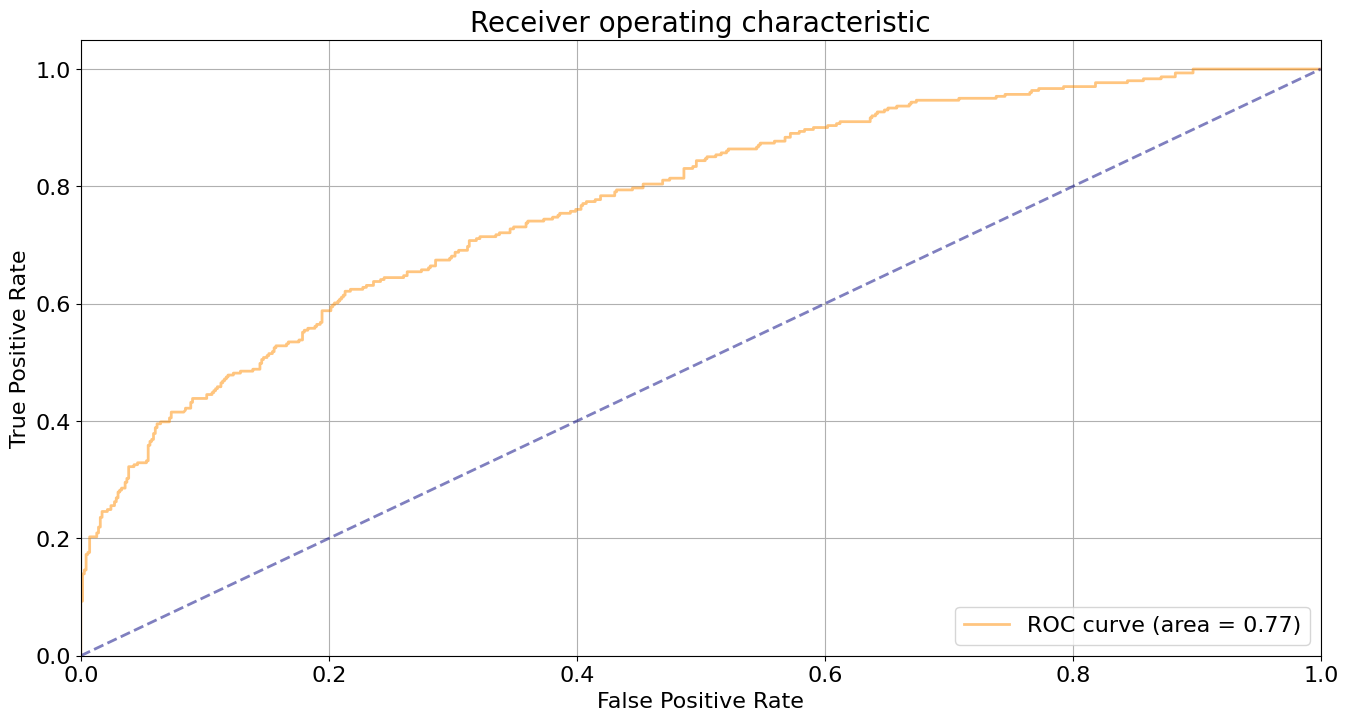

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### Best model training and validation prediction

In [69]:
best_params = rnd_search.best_params_

best_cat = CatBoostClassifier(**best_params, verbose=0)
best_cat.fit(
    df_train, 
    y_train, 
    cat_features=COLS_CATEGORICAL
)
y_pred_train = best_cat.predict(df_train)

In [70]:
y_pred = best_cat.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred),
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred),
    "f1_mean": f1_score(y_val, y_pred),
    "recall": recall_score(y_val, y_pred),    
    }
)
logging.info(f'-- best_cat val scores appended --')
# Log the results of the tuning process.
logging.info('The best hyperparameters are: {}'.format(rnd_search.best_params_))

#### Best iteration

## Final Model output

using df_test and the best_params

In [71]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,college_gpa,34.887501
1,parental_income,26.328737
2,sat_total_score,22.223542
3,parental_level_of_education,16.560220


#### predict test

In [72]:
y_pred_proba = best_cat.predict_proba(df_test)
y_pred = best_cat.predict(df_test)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "f1_mean": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),    
    }
)
logging.info(f'-- best_cat test scores appended --')

In [94]:
df = pd.DataFrame(scores)
df

,model,train auc,val auc,accuracy,precision,f1_mean,recall,test auc
0,CatBoostClassifier,0.612176,0.582222,0.728,0.643564,0.323383,0.215947,NaN
1,CatBoostClassifier,0.612176,NaN,0.744,0.623762,0.329843,0.224199,0.585674
2,HistGradientBoostingClassifier,0.646008,0.623316,0.640,0.427873,0.492958,0.581395,NaN
3,HistGradientBoostingClassifier,0.646008,NaN,0.637,0.397500,0.466960,0.565836,0.615324


In [ ]:
# student = {
#     "sat_total_score": 1400,
#     "parental_level_of_education": "bachelor's degree",
#     "parental_income": 125000,
#     "college_gpa": 3.2
# }